<a href="https://colab.research.google.com/github/jdscifi/StockIt/blob/developement/StockIt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Program Description

Program used for stock price analysis and prediction.

Program functions:
* Parsing news of stock prices from a website
* Logging of parsed information onto file
* Analysis of stocks from identified sector
* Prediction of stock price for identified stock

Project Group Members:
* Terence Yu
* Jaydutt Joshi
* Vineth Rajendran
* Shail Patel
* Swati Pal
* Kranthi Kandati

# Program Setup

Install needed libraries

In [1]:
% pip install yfinance
% pip install talos
% pip install ipython-autotime
% load_ext autotime

     |████████████████████████████████| 6.3 MB 7.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 51 kB 623 kB/s 
     |████████████████████████████████| 5.4 MB 7.5 MB/s 
     |████████████████████████████████| 9.8 MB 55.2 MB/s 
     |████████████████████████████████| 2.6 MB 38.4 MB/s 
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41609 sha256=fa034c54d7ee5ce46ec993aab13c2bbb2fbd4808d8e8172fe15471c72e75d45c
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-py3-none-any.whl size=3603 sha256=c8b54c4db4a3dcf31bf370a14ba702ca45a9ef78aaf5693691748caa063a9e89
  Stored in directory: /root/.cache/pip/wheels/1c/b4/c8/d1533d85f7fc617e3201c3f41b79fe49ae9284

Import required libraries

In [2]:
import os
import time
import datetime
import logging
import talos

import requests as rq
import pandas as pd
import numpy as np
import threading as thr
import yfinance as yf
import matplotlib.pyplot as plt

from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bs4 import BeautifulSoup
from IPython.display import clear_output 
from IPython.core.display import display, HTML
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

time: 4.2 s (started: 2021-11-30 15:32:25 +00:00)


Define constants

In [3]:
# Constants and Run Parameters
NEWS_DAYS_LIMIT = 7
STOCK_TICKER_FOR_PREDICTION='KO'
TRAIN_SAMPLE_SET_SIZE=0.8
STOCK_PRICE_HISTORY_PERIOD_SIZE='5y'
WINDOW_SIZE=60
AHEAD=1
LSTM_LAYER_UNIT_SIZE=50
DROPOUT_REGULARISATION_SIZE=0.2

time: 4.1 ms (started: 2021-11-30 15:32:29 +00:00)


# Website Scraping

Now we are setting parameter for displaying News, where we want 7 days news which will not contain today's date. Also, logging/saving article in log file and using method which will check whether all elements are True, potentially over an axis.

In [4]:
lock = thr.Lock()
date_threshold = datetime.datetime.now() - datetime.timedelta(NEWS_DAYS_LIMIT)
logging.basicConfig(filename="StockIt.log")
all_articles = pd.DataFrame()
stop_flag = False

time: 4.6 ms (started: 2021-11-30 15:32:29 +00:00)


Functions used to scrape the articles from the PR News Site

In [5]:
def store_data():
    try:
        global all_articles
        all_articles['time'] = all_articles["time"].dt.strftime("%b %d %Y %H:%M:%S")
        all_articles.to_csv("articles.csv", index=False)
    except Exception:
        logging.exception("Exception store_data\n", exc_info=True)


def parse_page(page_html,organisation):
    try:
        global all_articles, stop_flag, lock, date_threshold
        soup_parser = BeautifulSoup(page_html, features="html.parser")
        news_articles = soup_parser.findAll('a', class_='newsreleaseconsolidatelink')
        page_articles = []
        for article in news_articles:
            try:
                article_data = {"link": article['href'], "header": "", "time": None, "thumbnail": "", "summary": "","org":organisation}
                try:
                    date_tag = article.select("h3 > small")[0].text
                    article_data["time"] = datetime.datetime.strptime(date_tag, "%b %d, %Y, %H:%M ET")
                except Exception:
                    today = datetime.datetime.today()
                    article_data["time"] = datetime.datetime.strptime(date_tag, "%H:%M ET")
                    article_data["time"] = article_data["time"].replace(year=today.year, month=today.month,
                                                                        day=today.day)
                if article_data["time"] < date_threshold:
                    stop_flag = True
                    break
                articles_images = article.findAll("img")
                if len(articles_images) > 0:
                    article_data["thumbnail"] = article.findAll("img")[0]['src']
                article_data["header"] = str(article.select("h3")[0].text).split("\n")[2]
                article.small.decompose()
                article_data["summary"] = article.select("p")[0].text
                page_articles.append(article_data)
            except Exception:
                logging.exception("Exception article read!\n", exc_info=True)
        with lock:
            all_articles = all_articles.append(pd.DataFrame(page_articles))
            last_read = all_articles['time'].min()
            clear_output()
            print("Earliest News: {}\nNumber of articles scrapped: {}".format(last_read, len(all_articles)))
    except Exception:
        logging.exception("Exception parse_page", exc_info=True)


def collect_articles(page_no_,url_,organisation=None):
    try:
        attempts = 0
        while attempts < 5:
            try:
                temp = url_
                if page_no_ > 0:
                    temp = url_.format(page_no_)
                logging.info(temp)
                result = rq.get(temp)
                if result.status_code == 200:
                    parse_page(result.text,organisation)
                    break
                else:
                    logging.info("For page number {}, response received: {}\n".format(page_no_, str(result)))
            except Exception:
                logging.exception("Exception collect_articles\n", exc_info=True)
                attempts += 1
        if attempts > 5:
            logging.error("Could not read page number: {}".format(page_no_))
    except Exception:
        logging.exception("Exception collect_articles", exc_info=True)

time: 67.4 ms (started: 2021-11-30 15:32:29 +00:00)


Threaded call to scrape the website

In [6]:
try:
    page_no = 1
    while not stop_flag:
        thread = thr.Thread(target=collect_articles, args=(page_no,"https://www.prnewswire.com/news-releases/news-releases-list/?page={}&pagesize=100"))
        while thr.active_count() > 20:
            time.sleep(10)
        page_no += 1
        thread.start()
    wep = 0
    while thr.active_count() != 1:
        wep += 1
        if wep >= 10:
            break
        time.sleep(10)
    store_data()
except KeyboardInterrupt:
    store_data()
except Exception as e:
    print(e)
    logging.exception("main exception!", exc_info=True)

Earliest News: 2021-11-23 15:38:00
Number of articles scrapped: 3251
time: 2min (started: 2021-11-30 15:32:29 +00:00)


In [7]:
try:
    article_start = 0
    while True:
        clear_output()
        articles_html = """"""
        for index, na in all_articles.iloc[article_start: article_start+5].iterrows():
            art = """<a style="text-decoration:none;" href="{}"
        <h4><img width="50px" src="{}"> {}</h4>
        <p>{}</p>
        </a>
        <hr>
        <br>
        """.format(na['link'],na['thumbnail'],na['header'],na['summary'])
    #print(art)
            articles_html = articles_html + art
# print(articles_html)
        display(HTML(articles_html))
        user_input= input("Read more? y/n")
        if user_input != "y":
            break
        article_start +=5
        if (article_start + 5) > len(all_articles):
            break
except KeyboardInterrupt:
    print("Done Viewing")
except Exception as e:
    print(e)
    logging.exception("Exception News view", exc_info=True)

Read more? y/nn
time: 2min 15s (started: 2021-11-30 15:34:29 +00:00)


In [8]:
date_threshold = datetime.datetime.today() - datetime.timedelta(days=90)
pepsi_articles = []
print(len(all_articles))
try:
    pepsi_news = rq.get("https://www.prnewswire.com/news/pepsico%2C-inc./?page=1&pagesize=100")
    if pepsi_news.status_code == 200:
        parse_page(pepsi_news.text,"Pepsi")
    print(len(all_articles))
    coca_news = rq.get("https://www.prnewswire.com/search/news/?keyword=Coca%20Cola")
    if pepsi_news.status_code == 200:
        parse_page(pepsi_news.text,"Coca cola")
    print(len(all_articles))
except Exception as e:
    print(e)
    logging.exception("pepsi collection", exc_info=True)
finally:
    store_data()
    #

3251
3263
3275
time: 2.26 s (started: 2021-11-30 15:36:44 +00:00)


In [9]:
try:
    article_start = 0
    pc_news_articles = all_articles[all_articles['org']!=None]
    while True:
        clear_output()
        pc_articles_html = """"""
        for index, na in pc_news_articles.iloc[article_start:article_start+5].iterrows():
            art = """<a style="text-decoration:none;" href="{}"
        <h4><img width="50px" src="{}"> {}</h4>
        <p>{}</p>
        </a>
        <hr>
        <br>
        """.format(na['link'],na['thumbnail'],na['header'],na['summary'])
    #print(art)
            pc_articles_html = articles_html + art
# print(articles_html)
        display(HTML(pc_articles_html))
        user_input= input("Read more? y/n")
        if user_input != "y":
            break
        article_start +=5
        if (article_start + 5) > len(all_articles):
            break
except KeyboardInterrupt:
    print("Done Viewing")
except Exception as e:
    print(e)
    logging.exception("Exception News view", exc_info=True)

Read more? y/nn
time: 2.79 s (started: 2021-11-30 15:36:46 +00:00)


# Stock Price Analysis and Comparison

Now, we mention Pepsi symbol as PEP and further retrieve 6 months data, in which we display top 10 data.

In [10]:
pepsi = yf.Ticker("PEP")
pepsi_hist = pepsi.history(period="6mo")
pepsi_hist.head(10)
pepsi_hist.to_csv("pepsi.csv")

time: 261 ms (started: 2021-11-30 15:36:49 +00:00)


Same we will do for Cocacola, by which we can see Cocacola top 10 data. We can see, data consists of, Date, opening price of stock, closing price and High and low price(maximum and minimum), total voulme , dividends and splits of Stock.volume

In [11]:
coca = yf.Ticker("KO")
coca_hist = coca.history(period="6mo")
coca_hist.head(10)
coca_hist.to_csv("cocacola.csv")

time: 213 ms (started: 2021-11-30 15:36:50 +00:00)


Below line chart of Pepsi Vs Cocacola Stock price illustrates, the stock price from June 2021 to November 2021. In which, we can see Pepsi has been the highest stock price as compare to Cocacola,whereas we can see Pepsi stock has increased continously and in opposite to that Cocacola has fluctuating and stoped as price where it has seen in June.*italicized text*

Below line graph of Pepsi Vs Cocacola Market Cap depicts, the price distribution from June 2021 to November 2021. In which, we can see Cocacola has been the highest price as compare to Pepsi,whereas after November in the end both has almost same price. We have seen more variation in the Cocacola price as compare to Pepsi.

In [12]:
stp = figure(plot_width = 600, plot_height = 600, title = 'Pepsi vs Cocacola Stock Price', x_axis_label = 'Date',x_axis_type="datetime",y_axis_type="log", y_axis_label = 'Price')
stp.line(pepsi_hist.index, pepsi_hist["Close"], line_color="red", legend_label="Pepsi")
stp.line(coca_hist.index, coca_hist["Close"], line_color="blue", legend_label="Cocacola")
p = figure(plot_width = 800, plot_height = 600, title = 'Pepsi vs Cocacola Market Cap', x_axis_label = 'Date',x_axis_type="datetime",y_axis_type="log", y_axis_label = 'Market Cap')
p.line(pepsi_hist.index, pepsi_hist["Close"] * pepsi_hist["Volume"] ,line_color="red", legend_label="Pepsi")
p.line(coca_hist.index, coca_hist["Close"] * coca_hist["Volume"] ,line_color="blue", legend_label="Cocacola")
output_notebook()
show(row(stp, p))

time: 155 ms (started: 2021-11-30 15:36:50 +00:00)


Below figure of Pepsi Vs Cocacola Market Volume defines, the Volume distribution from June 2021 to November 2021. In which, we can see Cocacola has been the highest in terms of volume as compare to Pepsi. We have seen more variation in Pepsi Volume as compare to Cocacola. Volume is seen fluctuating always.

In [13]:
p = figure(plot_width = 1000, plot_height = 600, title = 'Pepsi vs Cocacola Market Volume', x_axis_label = 'Date',x_axis_type="datetime",y_axis_type="log", y_axis_label = 'Volume')
p.line(pepsi_hist.index, pepsi_hist["Volume"] ,line_color="red", legend_label="Pepsi")
p.line(coca_hist.index, coca_hist["Volume"] ,line_color="blue", legend_label="Coca Cola")
output_notebook()
show(p)

time: 109 ms (started: 2021-11-30 15:36:50 +00:00)


# Stock Price Prediction

In [14]:
# Talos Hyperparameter Dictionary
p = {    
    'epoch_size': [25, 50, 75, 100],
    'batch_size': [16, 32]
}

time: 1.89 ms (started: 2021-11-30 15:36:50 +00:00)


## Download Historical Pricing Data

In [15]:
# Download stock price data
tickerSymbol=STOCK_TICKER_FOR_PREDICTION
prices = yf.download(tickers=tickerSymbol, 
                     interval='1d', 
                     period=STOCK_PRICE_HISTORY_PERIOD_SIZE)

[*********************100%***********************]  1 of 1 completed
time: 262 ms (started: 2021-11-30 15:36:50 +00:00)


## Train-Test Split

Split the dataset into training and testing sets

In [16]:
# Split into train and test
# Note: order is important and should not be randomized
num_records_all = prices.shape[0]
num_records_train = int(round(num_records_all*TRAIN_SAMPLE_SET_SIZE))
train_set = prices.iloc[:num_records_train, 3:4]
test_set = prices.iloc[num_records_train:, 3:4]

time: 8.8 ms (started: 2021-11-30 15:36:50 +00:00)


Add additional record in test set to hold prediction data for new day

In [17]:
# Prepare updated index
updated_test_set_indices = test_set.index.to_list()
updated_test_set_indices.append(updated_test_set_indices[-1] + datetime.timedelta(days=1))

# Add another record in test_set for prediction of new closing price
test_set = test_set.append(test_set.iloc[-1:])

# Update index
test_set.index = updated_test_set_indices
test_set.tail()

,Close
2021-11-24,55.430000
2021-11-26,53.730000
2021-11-29,54.580002
2021-11-30,53.215000
2021-12-01,53.215000


time: 22.5 ms (started: 2021-11-30 15:36:50 +00:00)


## Training

Scale the training set for better machine learning performance

In [18]:
# Scale the training set
scaler = MinMaxScaler(feature_range = (0, 1))
train_set_scaled = scaler.fit_transform(train_set)

time: 9.84 ms (started: 2021-11-30 15:36:50 +00:00)


Prepare the training data by transforming it into format required by algorithm

In [19]:
train_x = []
train_y = []
for i in range(WINDOW_SIZE, num_records_train-1):
    train_x.append(train_set_scaled[i-WINDOW_SIZE:i, 0])
    train_y.append(train_set_scaled[i+AHEAD, 0])

train_x, train_y = np.array(train_x), np.array(train_y)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))

time: 9.09 ms (started: 2021-11-30 15:36:50 +00:00)


In [20]:
'''
Function called by Talos to create a model for each run.
Each run is different as Talos updates the params value iterating through each
possible combination of values
'''
def model(x_train, y_train, x_val, y_val, params):
  model = Sequential()
  # Add LSTM layer and dropout after regularisation
  model.add(LSTM(units = LSTM_LAYER_UNIT_SIZE, return_sequences = True, 
                 input_shape = (x_train.shape[1], 1)))
  model.add(Dropout(DROPOUT_REGULARISATION_SIZE))
  # Add LSTM layer and dropout after regularisation
  model.add(LSTM(units = LSTM_LAYER_UNIT_SIZE, return_sequences = True))
  model.add(Dropout(DROPOUT_REGULARISATION_SIZE))
  # Add LSTM layer and dropout after regularisation
  model.add(LSTM(units = LSTM_LAYER_UNIT_SIZE, return_sequences = True))
  model.add(Dropout(DROPOUT_REGULARISATION_SIZE))
  # Add LSTM layer and dropout after regularisation
  model.add(LSTM(units = LSTM_LAYER_UNIT_SIZE))
  model.add(Dropout(DROPOUT_REGULARISATION_SIZE))
  # Add Output layer
  model.add(Dense(units = 1))
  # Compiling the RNN
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  # Fitting the RNN to the Training set
  history = model.fit(x=x_train,
            y=y_train, 
            epochs=params['epoch_size'],
            batch_size=params['batch_size'],
            shuffle=False,
            verbose=0)
  return history, model

time: 21.4 ms (started: 2021-11-30 15:36:50 +00:00)


Run Talos to scan through each parameter combination to find results for each

In [21]:
t = talos.Scan(train_x, train_y, params=p, model=model, experiment_name='Stock Predictor')

100%|██████████| 8/8 [29:47<00:00, 223.48s/it]

time: 29min 47s (started: 2021-11-30 15:36:50 +00:00)


Show report of results for each run of hyper parameter optimization

In [22]:
r = talos.Reporting(t)
r.data

,start,end,duration,round_epochs,loss,batch_size,epoch_size
0,11/30/21-153650,11/30/21-153849,118.914376,25,0.004126,16,25
1,11/30/21-153850,11/30/21-154236,226.741204,50,0.003130,16,50
2,11/30/21-154237,11/30/21-154811,334.231578,75,0.002536,16,75
3,11/30/21-154812,11/30/21-155533,441.610184,100,0.002308,16,100
4,11/30/21-155534,11/30/21-155645,70.883032,25,0.004900,32,25
5,11/30/21-155645,11/30/21-155859,134.248258,50,0.003835,32,50
6,11/30/21-155900,11/30/21-160216,196.349841,75,0.002970,32,75
7,11/30/21-160217,11/30/21-160638,261.262117,100,0.002797,32,100


time: 23.9 ms (started: 2021-11-30 16:06:38 +00:00)


Display plot of loss obtained from each run

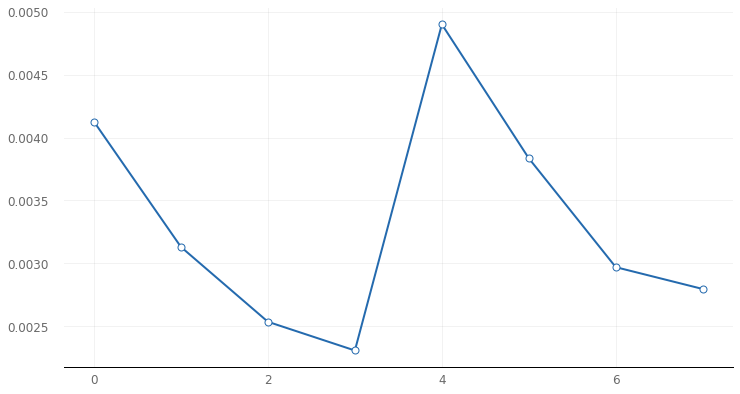

time: 358 ms (started: 2021-11-30 16:06:38 +00:00)


In [23]:
r.plot_line('loss')

Display hyper parameters with best results

In [24]:
r.best_params('loss', [], n=1, ascending=True)

array([[100, 16, 441.6101837158203, '11/30/21-155533', '11/30/21-154812',
        100, 0]], dtype=object)

time: 15.7 ms (started: 2021-11-30 16:06:39 +00:00)


## Testing

Prepare the testing data by transforming it into format required by algorithm

In [25]:
inputs = train_set[-60:].append(test_set)
inputs = inputs.values.reshape(-1, 1)
inputs = scaler.transform(inputs)

test_x = []
for i in range(WINDOW_SIZE, inputs.shape[0]):
    test_x.append(inputs[i-WINDOW_SIZE:i, 0])

test_x = np.array(test_x)
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

time: 13.4 ms (started: 2021-11-30 16:06:39 +00:00)


Run algorithm using best performing hyper parameters on test data for prediction

In [26]:
p = talos.Predict(t)
predicted_stock_price = p.predict(test_x, metric='loss', asc=True)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

time: 3.06 s (started: 2021-11-30 16:06:39 +00:00)


## Prediction Results

Display plot comparing actual prices and predicted prices

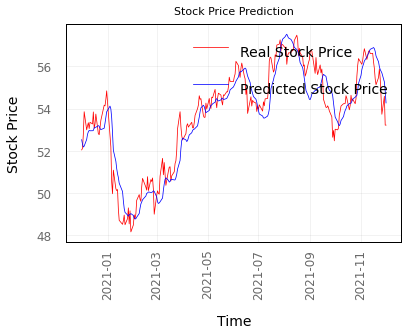

time: 339 ms (started: 2021-11-30 16:06:42 +00:00)


In [27]:
prices['Date']=prices.index
prices = prices.reset_index(drop=True)

plt.plot(updated_test_set_indices,test_set.values, color = 'red', label = 'Real Stock Price')
plt.plot(updated_test_set_indices,predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=90)
plt.show()

Compare last two prediction closing prices to provide a recommendation

In [28]:
# Comparing prediction prices of previous day and new day
previous_predicted_price = predicted_stock_price[-2]
predicted_closing_price = predicted_stock_price[-1]

print('Previous day predicted price:', previous_predicted_price)
print('New day predicted price:', predicted_closing_price)

if previous_predicted_price <= predicted_closing_price:
  recommendation = 'Buy'
else:
  recommendation = 'Sell'
print('Recommendation:', recommendation)

Previous day predicted price: [54.83487]
New day predicted price: [54.26732]
Recommendation: Sell
time: 5.99 ms (started: 2021-11-30 16:06:42 +00:00)


Compare last actual closing price with prediction to provide a recommendation

In [29]:
# Comparing actual closing price of previous day and new day predicted price
# Get actual last closing price
last_close = prices.iat[-1, 3]
last_close

print('Previous day actual price:', last_close)
print('New day predicted price:', predicted_closing_price)

if last_close <= predicted_closing_price:
  recommendation = 'Buy'
else:
  recommendation = 'Sell'
print('Recommendation:', recommendation)

Previous day actual price: 53.21500015258789
New day predicted price: [54.26732]
Recommendation: Buy
time: 7.89 ms (started: 2021-11-30 16:06:42 +00:00)
